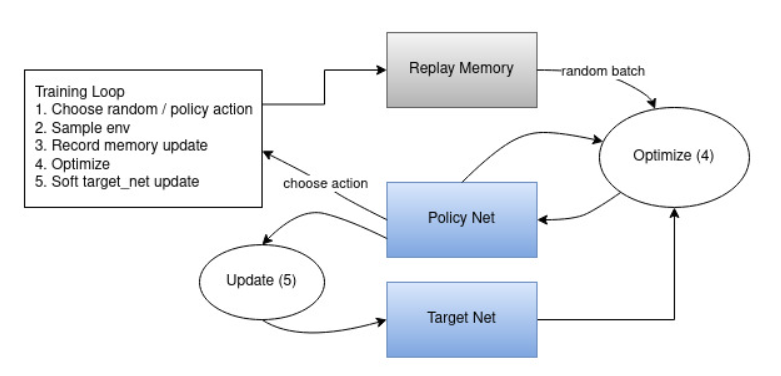

In [1]:
from itertools import count

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from cartpole_qnet import DEVICE, TAU, DQNAgent
from plot_utils import plot_durations, plot_states_over_time, setup_matplotlib

In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [3]:
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

Complete


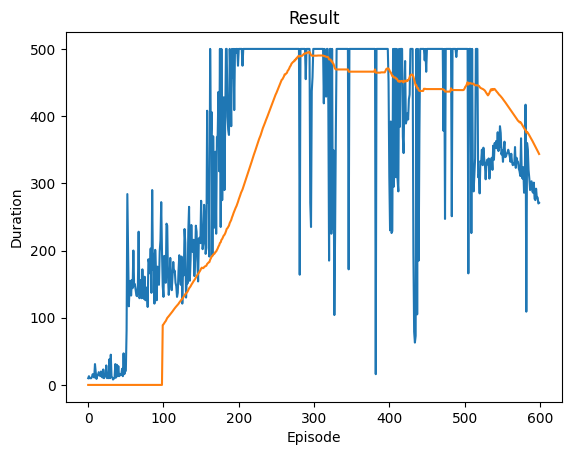

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# set up matplotlib
setup_matplotlib()

episode_durations = []

num_episodes = 600 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50

for _i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    for t in count():
        action = agent.select_action(state, env)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=DEVICE).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.update_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[
                key
            ] * (1 - TAU)
        agent.target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations(episode_durations)
            break

print('Complete')
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()

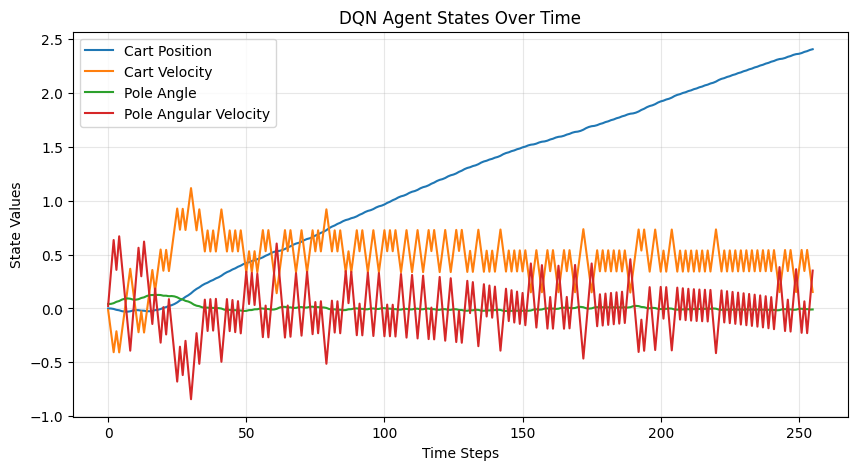

In [7]:
# Close training environment
env.close()

# Create a new visible environment for testing
test_env = gym.make('CartPole-v1', render_mode='human')

# Run one episode to capture states for visualization
state_history = []
state, info = test_env.reset()
state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)

for t in count():
    state_history.append(state)
    action = agent.select_action(state_tensor, test_env)
    state, reward, terminated, truncated, _ = test_env.step(action.item())
    done = terminated or truncated

    if not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)

    if done:
        state_history.append(state)
        break

# Plot the states over time from the final episode
state_history = np.array(state_history)
plot_states_over_time(state_history, title='DQN Agent States Over Time')

test_env.close()